In [1]:
import os
os.chdir('../')
os.chdir('../')
%pwd

'e:\\Deep Learning\\pytorch\\facial_emotion_prediction'

In [2]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import json

In [3]:
def define_transforms():
    transformer = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    return transformer

In [4]:
train_path = "artifacts/data_preparation/train"
val_path = "artifacts/data_preparation/val"
test_path = "artifacts/data_preparation/test"

In [5]:
def data_loader(train_path, val_path, transformer):
    train_loader = DataLoader(
        torchvision.datasets.ImageFolder(train_path, transform=transformer),
        batch_size=16, shuffle=True
    )
    test_loader = DataLoader(
        torchvision.datasets.ImageFolder(val_path, transform=transformer),
        batch_size=16, shuffle=True
    )
    return train_loader, test_loader

In [6]:
def class_name(train_path):
    root = pathlib.Path(train_path)
    classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
    return classes

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
def train_test_count(train_path, test_path):
    train_count = len(glob.glob(train_path + '/**/*.jpg'))
    test_count = len(glob.glob(test_path + '/**/*.jpg'))
    return train_count, test_count

In [9]:
transformer = define_transforms()
train_loader, val_loader = data_loader(train_path, val_path, transformer)
classes = class_name(train_path)
print(classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
train_count, val_count = train_test_count(train_path, val_path)

In [11]:
print(train_count, ",", val_count)

25117 , 7178


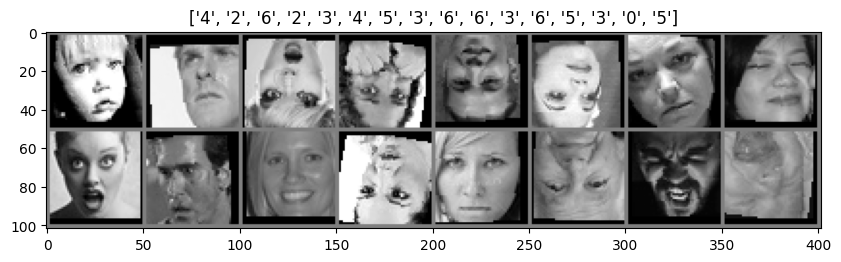

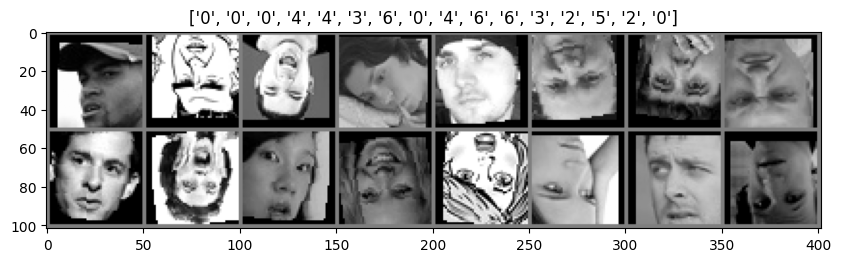

In [12]:
import matplotlib.pyplot as plt
import torchvision

def show_images(loader):
    # Get a batch of images and labels
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Create a grid from batch
    img_grid = torchvision.utils.make_grid(images)

    # Convert to numpy for visualization
    img_grid = img_grid / 2 + 0.5  # unnormalize
    np_img = img_grid.numpy()

    # Plot the images
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title([str(label.item()) for label in labels])
    plt.show()

# Example usage:
train_loader, val_loader = data_loader(train_path, val_path, transformer)
show_images(train_loader)
show_images(val_loader)

In [13]:
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
batch_size = 32
weight_decay = 1e-4  
step_size = 5 
gamma = 0.7  
num_classes = 7 

# Load EfficientNet-B7 model with pretrained weights
model = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to C:\Users\Karma/.cache\torch\hub\checkpoints\efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:53<00:00, 5.03MB/s] 


In [14]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss, train_accuracy = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Scheduler step
    scheduler.step()

    # Validation phase
    model.eval()
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction == labels.data))

    val_accuracy = val_accuracy / val_count
    val_loss = val_loss / val_count

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/10


KeyboardInterrupt: 